In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
#from skorch import NeuralNetRegressor

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, RNN
from tensorflow.keras import activations, initializers, regularizers, constraints

class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN."""
    def __init__(self, units, activation='tanh', use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer=self.recurrent_initializer,
                                                name='recurrent_kernel',
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.matmul(inputs, self.kernel)
        if self.use_bias:
            h = tf.nn.bias_add(h, self.bias)
        output = h + tf.matmul(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        return output, [output]

    def get_config(self):
        return {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'dropout': self.dropout,
            'recurrent_dropout': self.recurrent_dropout
        }

class AlphaRNN(RNN):
    """Fully-connected RNN where the output is to be fed back to input."""
    def __init__(self, units, **kwargs):
        cell = AlphaRNNCell(units, **kwargs)
        super(AlphaRNN, self).__init__(cell, **kwargs)

    @property
    def units(self):
        return self.cell.units

    def get_config(self):
        config = super(AlphaRNN, self).get_config()
        config.update({'units': self.units})
        return config

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, RNN
from tensorflow.keras import activations, initializers, regularizers, constraints

class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer."""
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid',
                 use_bias=True, kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal', bias_initializer='zeros',
                 kernel_regularizer=None, recurrent_regularizer=None,
                 bias_regularizer=None, kernel_constraint=None,
                 recurrent_constraint=None, bias_constraint=None,
                 dropout=0., recurrent_dropout=0., implementation=2, **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer=self.recurrent_initializer,
            name='recurrent_kernel',
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(2 * self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        dp_mask = None
        rec_dp_mask = None

        if 0 < self.dropout < 1:
            dp_mask = self.dropout_mask(inputs, self.dropout, training=True)
        if 0 < self.recurrent_dropout < 1:
            rec_dp_mask = self.dropout_mask(prev_output, self.recurrent_dropout, training=True)

        h = tf.matmul(inputs, self.kernel)
        if dp_mask is not None:
            h *= dp_mask

        if self.bias is not None:
            h = tf.nn.bias_add(h, self.bias[:self.units])

        rec_h = tf.matmul(prev_output, self.recurrent_kernel)
        if rec_dp_mask is not None:
            rec_h *= rec_dp_mask

        if self.bias is not None:
            rec_h = tf.nn.bias_add(rec_h, self.bias[self.units:])

        output = self.activation(h + rec_h)
        return output, [output]

    def get_config(self):
        config = super(AlphatRNNCell, self).get_config()
        config.update({
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'recurrent_activation': activations.serialize(self.recurrent_activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'dropout': self.dropout,
            'recurrent_dropout': self.recurrent_dropout
        })
        return config

class AlphatRNN(RNN):
    """Fully-connected RNN where the output is to be fed back to input."""
    def __init__(self, units, **kwargs):
        cell = AlphatRNNCell(units, **kwargs)
        super(AlphatRNN, self).__init__(cell, **kwargs)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        return super(AlphatRNN, self).call(inputs, mask=mask, training=training, initial_state=initial_state)

    def get_config(self):
        config = super(AlphatRNN, self).get_config()
        return config

In [4]:
df = pd.read_csv('../data/coinbase.csv', index_col = 1)
df.index = pd.to_datetime(df.index)

In [5]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [6]:
df = df.bfill()
nof_missing_values = sum(np.isnan(df['USD']))
print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


In [7]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon

In [9]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [10]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.0945571633757587
p-value: 0.2467088183939536,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


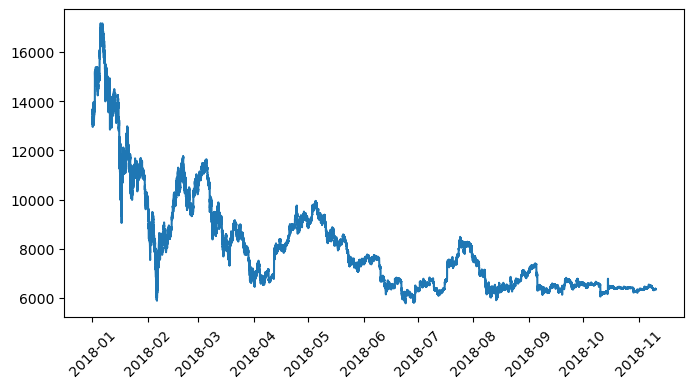

In [11]:
plt.figure(figsize = (8,4))
plt.plot(df)
plt.grid(False)
plt.xticks(rotation = 45)
plt.show()

In [12]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [13]:
T = len(df[use_features])
sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [14]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


Text(0.5, 1.0, 'Partial Autocorrelation function')

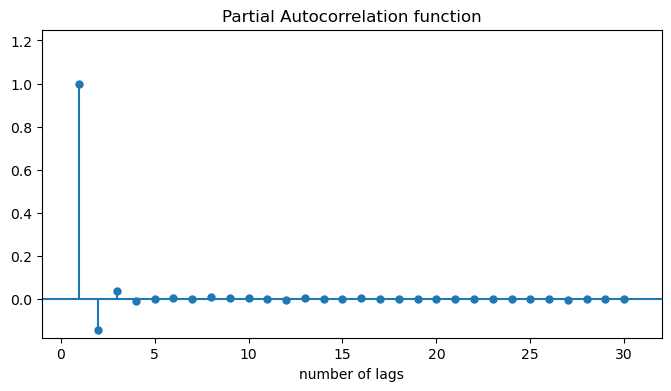

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(np.log(df), auto_ylims = True, lags = range(1, 31), title = 'PACF of KOSPI log Index', ax = ax)
plt.xlabel('number of lags')
plt.grid(False)
plt.title('Partial Autocorrelation function')

In [17]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

In [18]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = np.float64(df_train.mean())
sigma = np.float64(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_35567/3391573592.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = np.float64(df_train.mean())
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_35567/3391573592.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = np.float64(df_train.std())


In [19]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [20]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train = df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [21]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(361337, 4, 1), (361337, 1), (90330, 4, 1), (90330, 1)]


In [32]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(
        AlphatRNN(
            n_units, 
            activation='tanh', 
            recurrent_activation='sigmoid', 
            kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            recurrent_initializer=keras.initializers.orthogonal(seed), 
            kernel_regularizer=l1(l1_reg), 
            input_shape=(x_train.shape[1], x_train.shape[-1]), 
        )
    )  
    model.add(
        Dense(
            1, kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            kernel_regularizer=l1(l1_reg)
        )
    )
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam'
    )
    return model

def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(
        AlphaRNN(
            n_units, 
            activation='tanh', 
            kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            recurrent_initializer=keras.initializers.orthogonal(seed), 
            kernel_regularizer=l1(l1_reg), 
            input_shape=(x_train.shape[1], x_train.shape[-1]), 
        )
    )
    model.add(
        Dense(
            1, kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            kernel_regularizer=l1(l1_reg)
        )
    )
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam'
    )
    return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(
        SimpleRNN(
            n_units, 
            activation='tanh', 
            kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            recurrent_initializer=keras.initializers.orthogonal(seed), 
            kernel_regularizer=l1(l1_reg), 
            input_shape=(x_train.shape[1], x_train.shape[-1]), 
            unroll=True, 
            stateful=False
        )
    )  
    model.add(
        Dense(
            1, kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            kernel_regularizer=l1(l1_reg)
        )
    )
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam'
    )
    return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(
        GRU(
            n_units, 
            activation='tanh', 
            kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            recurrent_initializer=keras.initializers.orthogonal(seed), 
            kernel_regularizer=l1(l1_reg), 
            input_shape=(x_train.shape[1], x_train.shape[-1]), 
            unroll=True
        )
    )  
    model.add(
        Dense(
            1, kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            kernel_regularizer=l1(l1_reg)
        )
    )
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam'
    )
    return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(
        LSTM(
            n_units, 
            activation='tanh', 
            kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed),
            recurrent_initializer=keras.initializers.orthogonal(seed), 
            kernel_regularizer=l1(l1_reg), 
            input_shape=(x_train.shape[1], x_train.shape[-1]),
            unroll=True
        )
    ) 
    model.add(
        Dense(
            1, kernel_initializer=keras.initializers.glorot_uniform(seed), 
            bias_initializer=keras.initializers.glorot_uniform(seed), 
            kernel_regularizer=l1(l1_reg)
        )
    )
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam'
    )
    return model

In [33]:
max_epochs = 2000
batch_size = 1000

In [34]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=3e-5, restore_best_weights=True)

In [35]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'alpharnn': {
        'model': None, 'function': AlphaRNN_, 'l1_reg': 0.0, 'H': 10, 
        'color': 'green', 'label': '$\\alpha$-RNN' }, 
    'alphatrnn': {
        'model': None, 'function': AlphatRNN_, 'l1_reg': 0.0, 'H': 5, 
        'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
    'gru': {
        'model': None, 'function': GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_, 'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [36]:
do_training = True # Set to False if you wish to train the models
if do_training is False:
    custom_objects = {'AlphaRNN': AlphaRNN, 'AlphatRNN': AlphatRNN}
    for key in params.keys():
        params[key]['model'] = load_model('trained-RNNs/RNNs-HFT-' + key + '.hdf5', custom_objects=custom_objects)

In [37]:
cross_val = False # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=1)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

In [38]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(
            x_train, 
            y_train, 
            epochs=max_epochs, 
            verbose=0,
            batch_size=batch_size, 
            callbacks=[es], 
            shuffle=False
        )
        params[key]['model'] = model

Training rnn model
Restoring model weights from the end of the best epoch: 102.
Epoch 152: early stopping
Training alpharnn model


ValueError: The RNN cell should have a `state_size` attribute (tuple of integers, one integer per RNN state). Received: cell=<__main__.AlphaRNNCell object at 0x30b42e390>